In [30]:
import polars as pl
from src.paths import (
    PYTHON_VULNERABILITY_FIXES_DATA_PATH,
    PYTHON_CODE_FIXES_DATA_PATH,
    PYTHON_CODE_FIXES_WITH_CONTEXT_DATA_PATH,
    PYTHON_CODE_UNITS_DATA_PATH,
    PYTHON_CODE_CONTEXT_DATA_PATH,
    PYTHON_VULNERABILITIES_WITHOUT_BALANCING,
)
from tqdm import tqdm
import jedi
from git import Repo
from typing import Any
import jedi.api
import jedi.common
import json
import shutil
import logging
import matplotlib.pyplot as plt
import tempfile
import subprocess
from pathlib import Path
import json

from src.process_code_changes import get_changes

## Filter out data

In [3]:
# python_commit_data = commit_data_only_top_langs.filter(pl.col("language") == "Python")
python_vulnerability_fixes = pl.read_parquet(PYTHON_VULNERABILITY_FIXES_DATA_PATH)
print(python_vulnerability_fixes.unique("vulnerability_id").shape[0])
python_vulnerability_fixes = python_vulnerability_fixes.group_by('vulnerability_id', 'repo', 'commit', 'pull_request_number', 'file', 'patch', 'patch_time', 'commit_source', 'file_extension', 'language').agg(pl.col("cwe_id"))
python_vulnerability_fixes = python_vulnerability_fixes.unique("patch")
print(python_vulnerability_fixes.unique("vulnerability_id").shape[0])


1805
1802


## Filter out data connected with test functionallity

In [4]:
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    (
        pl.col("file").str.contains(r"\/{0,1}[tT][eE][sS][tT][sS]{0,1}\/")
        | pl.col("patch").str.contains("pytest")
        | pl.col("patch").str.contains("unittest")
    ).not_()
)
python_vulnerability_fixes.unique("vulnerability_id").shape[0]

1552

In [5]:
exclude_langs = [
    "txt",
    "md",
    "JSON",
    "YAML",
    "bugfix",
    "cfg",
    "rst",
    "toml",
    "lock",
    "ini",
    "in",
    "gitignore",
    "sample",
    "pem",
    "feature",
    "tif",
    "security",
    "proto",
    "conf",
    "spec",
    "bin",
    "misc",
    "pyi",
    "pxi",
    "fli",
    "gif",
    "tpl",
    "graphql",
    "http",
    "sgi",
    "pyx",
    "inc"
]
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    (
        pl.col("file").str.split(".").list.last().is_in(exclude_langs)
    ).not_(),
    pl.col("file").str.contains(r"__.*__.py").not_()
)
python_vulnerability_fixes.unique("vulnerability_id").shape[0]

1507

## Process missing commit

In [6]:
print(python_vulnerability_fixes.filter(pl.col("commit").is_null()))
python_vulnerability_fixes = python_vulnerability_fixes.with_columns(
    pl.when(pl.col("pull_request_number") == 24391)
    .then(pl.lit("86664c9405136a4904775c52e6caf100a474ec58"))
    .otherwise(pl.col("commit"))
    .alias("commit")
)
print(python_vulnerability_fixes.filter(pl.col("commit").is_null()))
# No changes related to python: https://github.com/pyca/pyopenssl/commit/6bbf44a00b35fb28df1f66aa194b2fe95eab1ab2
# Very big change: https://github.com/transifex/transifex-client/commit/e0d1f8b38ec1a24e2999d63420554d8393206f58
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    ~pl.col("commit").is_in(
        [
            "6bbf44a00b35fb28df1f66aa194b2fe95eab1ab2",
            "e0d1f8b38ec1a24e2999d63420554d8393206f58",
            "5f7496481bd3db1d06a2d2e62c0dce960a1fe12b",
            # Not exists in repo
            "13336272e32872247fa7d17e964ccd88ec8d1376",
            "2bfe358043096fdba9e2a4cf0f5740102b37fd8f",
        ]
    )
)
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    pl.col("file") != "setup.py"
)
print(python_vulnerability_fixes.filter(pl.col("commit").is_null()))

shape: (33, 11)
┌────────────┬────────────┬────────┬────────────┬───┬───────────┬───────────┬──────────┬───────────┐
│ vulnerabil ┆ repo       ┆ commit ┆ pull_reque ┆ … ┆ commit_so ┆ file_exte ┆ language ┆ cwe_id    │
│ ity_id     ┆ ---        ┆ ---    ┆ st_number  ┆   ┆ urce      ┆ nsion     ┆ ---      ┆ ---       │
│ ---        ┆ str        ┆ str    ┆ ---        ┆   ┆ ---       ┆ ---       ┆ str      ┆ list[str] │
│ str        ┆            ┆        ┆ i64        ┆   ┆ str       ┆ str       ┆          ┆           │
╞════════════╪════════════╪════════╪════════════╪═══╪═══════════╪═══════════╪══════════╪═══════════╡
│ 2013-10009 ┆ DrAzraelTo ┆ null   ┆ 1          ┆ … ┆ github    ┆ py        ┆ Python   ┆ ["CWE-89" │
│            ┆ d/pyChao   ┆        ┆            ┆   ┆           ┆           ┆          ┆ ]         │
│ 2013-4439  ┆ saltstack/ ┆ null   ┆ 7356       ┆ … ┆ github    ┆ py        ┆ Python   ┆ [null]    │
│            ┆ salt       ┆        ┆            ┆   ┆           ┆          

In [ ]:
python_vulnerability_fixes.filter(pl.col("vulnerability_id") == "2022-29198").unique("language")

vulnerability_id,repo,commit,pull_request_number,file,patch,patch_time,commit_source,file_extension,language,cwe_id
str,str,str,i64,str,str,"datetime[μs, UTC]",str,str,str,list[str]
"""2022-29198""","""tensorflow/tensorflow""","""ea50a40e84f6bff15a0912728e35b6…",null,"""tensorflow/core/kernels/sparse…","""@@ -67,6 +67,13 @@ class Spars…",2022-05-02 23:16:54 UTC,"""github""","""cc""","""C/C++""","[""CWE-20""]"


In [82]:
if PYTHON_CODE_FIXES_DATA_PATH.exists():
    print("Reading code fixes")
    code_unit_changes = pl.read_parquet(PYTHON_CODE_FIXES_DATA_PATH).to_dicts()
else:
    code_unit_changes: list[dict[str, Any]] = []

repos: dict[str, Repo] = {}

grouped_vulnerabilities = (
    python_vulnerability_fixes.group_by(
        "repo", "vulnerability_id", "commit", "commit_source", "cwe_id"
    )
    .agg(pl.col("patch"), pl.col("file"), pl.col("language"))
    .sample(fraction=1, shuffle=True)
)
errors: list[dict[str, Any]] = []
checked_commits = set([change["commit"] for change in code_unit_changes])


vulnerabilities_to_check = grouped_vulnerabilities.to_dicts()


for commit_data_row in tqdm(vulnerabilities_to_check):
    if commit_data_row["commit"] in checked_commits:
        continue
    try:
        get_changes(commit_data_row)
    except Exception as e:
        logging.exception(f"Error in {commit_data_row}")

Reading code fixes


  0%|          | 0/2327 [00:00<?, ?it/s]

In [ ]:
print(commit_data_row)

In [6]:
new_code_unit_changes = []
new_code_context_changes = []

for commit_data_file in PYTHON_CODE_UNITS_DATA_PATH.rglob("*.json"):
    try:
        with commit_data_file.open() as f:
            new_code_unit_changes.append(json.load(f))
    except:
        print(commit_data_file)
        commit_data_file.unlink()
for commit_data_file in PYTHON_CODE_CONTEXT_DATA_PATH.rglob("*.json"):
    try:
        with commit_data_file.open() as f:
            new_code_context_changes.append(json.load(f))
    except:
        print(commit_data_file)
        commit_data_file.unlink()

pl.DataFrame(new_code_unit_changes).write_parquet(PYTHON_CODE_FIXES_DATA_PATH)
pl.DataFrame(new_code_context_changes).write_parquet(PYTHON_CODE_FIXES_WITH_CONTEXT_DATA_PATH)

## Data cleaning

In [9]:
code_unit_changes_df = pl.read_parquet(PYTHON_CODE_FIXES_DATA_PATH)
code_unit_changes_df = code_unit_changes_df.filter(
    # pl.col("vulnerability_id").is_in(excluded_vulns).not_(),
    pl.col("new_file") != "setup.py",
    pl.col("old_file") != "setup.py",
).with_columns(
    pl.col("code_unit_after_fix").str.replace_all(r"\n\s*\n", "\n").str.strip_chars(),
    pl.col("code_unit_before_fix").str.replace_all(r"\n\s*\n", "\n").str.strip_chars(),
)
code_unit_changes_df.describe()

statistic,commit,repo,new_file,patch,code_unit_after_fix,vulnerability_id,cwe_id,old_file,code_unit_before_fix
str,str,str,str,str,str,str,f64,str,str
"""count""","""4401""","""4401""","""4401""","""4401""","""4401""","""4401""",4401.0,"""4401""","""4401"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null
"""min""","""001b0634cd309e372edb6d7d95d083…","""389ds/389-ds-base""",""".devcontainer/library-scripts/…","""@@ -1 +1 @@ -__version__ = ""1.…","""""","""2013-0208""",null,""".devcontainer/library-scripts/…",""""""
"""25%""",null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null
"""max""","""ffc095a3e5acc1c404773a0510e6d0…","""zwczou/weixin-python""","""zproject/urls.py""","""@@ -99,7 +99,9 @@ extern ""C"" {…","""} else { actionsTempla…","""GHSA-x563-6hqv-26mr""",null,"""zproject/urls.py""","""}, ""scope"": { …"


In [10]:
code_unit_changes_df = code_unit_changes_df.filter(
    ((pl.col("code_unit_after_fix").str.strip_chars() == "") & (pl.col("code_unit_before_fix").str.strip_chars() == "")).not_(), 
)
code_unit_changes_df.describe()

statistic,commit,repo,new_file,patch,code_unit_after_fix,vulnerability_id,cwe_id,old_file,code_unit_before_fix
str,str,str,str,str,str,str,f64,str,str
"""count""","""4378""","""4378""","""4378""","""4378""","""4378""","""4378""",4378.0,"""4378""","""4378"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null
"""min""","""001b0634cd309e372edb6d7d95d083…","""389ds/389-ds-base""",""".devcontainer/library-scripts/…","""@@ -1 +1 @@ -__version__ = ""1.…","""""","""2013-0208""",null,""".devcontainer/library-scripts/…",""""""
"""25%""",null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null
"""max""","""ffc095a3e5acc1c404773a0510e6d0…","""zwczou/weixin-python""","""zproject/urls.py""","""@@ -99,7 +99,9 @@ extern ""C"" {…","""} else { actionsTempla…","""GHSA-x563-6hqv-26mr""",null,"""zproject/urls.py""","""}, ""scope"": { …"


#### Filter too long samples

In [49]:
SAMPLE_MAX_LEN = 128000
filtered_vulnerabilities = code_unit_changes_df.select(
    "vulnerability_id", 
    pl.col("code_unit_after_fix").str.len_chars().alias("code_unit_after_fix_len"),
    pl.col("code_unit_before_fix").str.len_chars().alias("code_unit_before_fix_len"),
).group_by(
    "vulnerability_id"
).agg(pl.col("code_unit_after_fix_len").sum(), pl.col("code_unit_before_fix_len").sum()).with_columns(
    total_len=pl.col("code_unit_after_fix_len") + pl.col("code_unit_before_fix_len")
).filter(pl.col("total_len") < 128000).select("vulnerability_id").unique("vulnerability_id")

code_unit_changes_df = code_unit_changes_df.join(filtered_vulnerabilities, on="vulnerability_id")
code_unit_changes_df.describe()

statistic,commit,repo,new_file,patch,code_unit_after_fix,vulnerability_id,cwe_id,old_file,code_unit_before_fix
str,str,str,str,str,str,str,f64,str,str
"""count""","""4142""","""4142""","""4142""","""4142""","""4142""","""4142""",4142.0,"""4142""","""4142"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null
"""min""","""001b0634cd309e372edb6d7d95d083…","""389ds/389-ds-base""",""".devcontainer/library-scripts/…","""@@ -1 +1 @@ -__version__ = ""1.…","""""","""2013-0208""",null,""".devcontainer/library-scripts/…",""""""
"""25%""",null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null
"""max""","""ffc095a3e5acc1c404773a0510e6d0…","""zwczou/weixin-python""","""zproject/urls.py""","""@@ -99,7 +99,9 @@ extern ""C"" {…","""} else { actionsTempla…","""GHSA-x563-6hqv-26mr""",null,"""zproject/urls.py""","""}, ""scope"": { …"


In [50]:
sorted(code_unit_changes_df.with_columns(
    pl.col("new_file").str.split(".").list.last().alias("lang")
).group_by("vulnerability_id").agg("lang").with_columns(pl.col("lang").list.unique()).unique("lang").filter(pl.col("lang").list.contains("py").not_()).select("vulnerability_id").to_series().to_list())

['2018-10861',
 '2021-28359',
 '2021-41104',
 '2021-41206',
 '2022-25882',
 '2022-35941',
 '2022-41891',
 '2022-4526',
 '2023-46249',
 '2023-52266',
 '2023-6507',
 '2023-7152',
 '2024-10965',
 '2024-21485',
 '2024-49377',
 '2024-8948']

### Duplicate code detection

In [51]:
concated_code_units = pl.concat(
    [code_unit_changes_df.filter(pl.col("code_unit_after_fix").str.strip_chars() != "").select(
        pl.col("code_unit_after_fix").alias("code_unit"), pl.col("commit"), pl.col("repo")
    ),
    code_unit_changes_df.filter(pl.col("code_unit_before_fix").str.strip_chars() != "").select(
        pl.col("code_unit_before_fix").alias("code_unit"), pl.col("commit"), pl.col("repo")
    )]
)

print(concated_code_units.group_by("code_unit").agg("commit", "repo").filter(pl.col("commit").list.len() > 1).shape[0])


557


#### Filter duplicates in vulnerability

In [52]:
without_duplicates = code_unit_changes_df.unique(["vulnerability_id", "code_unit_before_fix", "code_unit_after_fix"])
without_duplicates = without_duplicates.filter(
    pl.col("code_unit_after_fix").str.strip_chars() != pl.col("code_unit_before_fix").str.strip_chars()
)
print(without_duplicates.describe())

shape: (9, 10)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬────────┬───────────┬───────────┐
│ statistic  ┆ commit     ┆ repo      ┆ new_file  ┆ … ┆ vulnerabi ┆ cwe_id ┆ old_file  ┆ code_unit │
│ ---        ┆ ---        ┆ ---       ┆ ---       ┆   ┆ lity_id   ┆ ---    ┆ ---       ┆ _before_f │
│ str        ┆ str        ┆ str       ┆ str       ┆   ┆ ---       ┆ f64    ┆ str       ┆ ix        │
│            ┆            ┆           ┆           ┆   ┆ str       ┆        ┆           ┆ ---       │
│            ┆            ┆           ┆           ┆   ┆           ┆        ┆           ┆ str       │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪════════╪═══════════╪═══════════╡
│ count      ┆ 3545       ┆ 3545      ┆ 3545      ┆ … ┆ 3545      ┆ 3545.0 ┆ 3545      ┆ 3545      │
│ null_count ┆ 0          ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0.0    ┆ 0         ┆ 0         │
│ mean       ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆

#### Consistency checks

In [53]:
## Looking for code units that are the same before and after the fix

inconsistent_code_units = without_duplicates.select("vulnerability_id", "code_unit_before_fix").filter(
    pl.col("code_unit_before_fix").str.strip_chars() != ""
).join(
    without_duplicates.select("vulnerability_id", "code_unit_after_fix").filter(
        pl.col("code_unit_after_fix").str.strip_chars() != ""
    ), 
    how="cross"
).filter(pl.col("code_unit_before_fix") == pl.col("code_unit_after_fix"))

inconsistent_code_units

vulnerability_id,code_unit_before_fix,vulnerability_id_right,code_unit_after_fix
str,str,str,str
"""2019-14859""","""def read_length(string): i…","""2019-14859""","""def read_length(string): i…"
"""2016-6903""","""def check_secure(line, conf, s…","""2016-6903""","""def check_secure(line, conf, s…"
"""2013-2161""","""def account_listing_response( …","""2013-2161""","""def account_listing_response( …"
"""2022-3362""","""class RdiffwebApp(Application)…","""2022-4018""","""class RdiffwebApp(Application)…"
"""GHSA-cg34-w3fm-82h3""","""def _build_redirect_request(so…","""GHSA-4q82-j5c2-g2c5""","""def _build_redirect_request(so…"
…,…,…,…
"""2024-32498""","""class _ConvertImage(task.Task)…","""2024-32498""","""class _ConvertImage(task.Task)…"
"""2024-32882""","""from wagtail.admin.forms.model…","""2024-32882""","""from wagtail.admin.forms.model…"
"""2022-3326""","""class UserObject(object): …","""2022-3179""","""class UserObject(object): …"


#### Fix and check consistency

Usually, there are a few vulnerabilities in code unit. Some of them was fixed later.
There aren't so much bad cases, so we can just drop inconsistent rows

Code examples on right have hidden vulnerability. We can exclude such vulnerabilities from dataset

In [54]:
inconsistent_vulns = set(inconsistent_code_units.select("vulnerability_id_right").to_series().to_list())
consistency_fix_vulnerabilities = without_duplicates.filter(
    pl.col("vulnerability_id").is_in(inconsistent_vulns).not_()
)
consistency_fix_vulnerabilities.describe()

statistic,commit,repo,new_file,patch,code_unit_after_fix,vulnerability_id,cwe_id,old_file,code_unit_before_fix
str,str,str,str,str,str,str,f64,str,str
"""count""","""3410""","""3410""","""3410""","""3410""","""3410""","""3410""",3410.0,"""3410""","""3410"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null
"""min""","""001b0634cd309e372edb6d7d95d083…","""389ds/389-ds-base""",""".devcontainer/library-scripts/…","""@@ -1 +1 @@ -__version__ = ""1.…","""""","""2013-0208""",null,""".devcontainer/library-scripts/…",""""""
"""25%""",null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null
"""max""","""ffc095a3e5acc1c404773a0510e6d0…","""zwczou/weixin-python""","""zproject/urls.py""","""@@ -99,7 +99,9 @@ extern ""C"" {…","""} else { actionsTempla…","""GHSA-x563-6hqv-26mr""",null,"""zproject/urls.py""","""}, ""scope"": { …"


In [55]:
consistency_fix_vulnerabilities.select("vulnerability_id", "code_unit_before_fix").filter(
    pl.col("code_unit_before_fix").str.strip_chars() != ""
).join(
    consistency_fix_vulnerabilities.select("vulnerability_id", "code_unit_after_fix").filter(
        pl.col("code_unit_after_fix").str.strip_chars() != ""
    ), 
    how="cross"
).filter(pl.col("code_unit_before_fix") == pl.col("code_unit_after_fix")).shape[0]

0

### Advanced filtering with duplicate searcher tool

In [56]:
slice_data = without_duplicates.slice(offset=0, length=100)

with tempfile.TemporaryDirectory() as temp_dir:
    for row in slice_data.iter_rows(named=True):
        path = Path(f"{temp_dir}/new_data/{row['commit']}/{row['new_file']}")
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "w") as f:
            f.write(row["code_unit_after_fix"])
            
        path = Path(f"{temp_dir}/old_data/{row['commit']}/{row['old_file']}")
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "w") as f:
            f.write(row["code_unit_before_fix"])

    similarity = json.loads(subprocess.getoutput(
        "cd /Users/somen/Zavodi/unik/duplicate-code-detection-tool/ && "
        "source .venv/bin/activate && "
        f"python -W ignore duplicate_code_detection.py --json True --file-extensions py -d {temp_dir}/new_data/ {temp_dir}/old_data/",
    ))

SIMILARITY_DATA_PATH = Path("data/similarity.json")
SIMILARITY_DATA_PATH.write_text(json.dumps(similarity))

3950854

In [57]:
similarity = json.loads(SIMILARITY_DATA_PATH.read_text())
similarity = pl.DataFrame(
    [
        {
            "path_1": left_path, 
            "path_2": right_path, 
            "similarity": value
        }  
        for left_path, values in similarity.items() for right_path, value in values.items()
    ]
)
similarity = similarity.with_columns(
    # THIS LINES ARE NOT CROSS PLATFORM. Change index in .get(...) call accordingly to your own path
    pl.col("path_1").str.split("/").list.get(8).alias("commit_1"), 
    pl.col("path_1").str.split("/").list.slice(9).list.join("/").alias("file_path_1"), 
    (pl.col("path_1").str.split("/").list.get(7) == "new_data").alias("is_new_1"),
    pl.col("path_2").str.split("/").list.get(8).alias("commit_2"),
    pl.col("path_2").str.split("/").list.slice(9).list.join("/").alias("file_path_2"),
    (pl.col("path_2").str.split("/").list.get(7) == "new_data").alias("is_new_2"),
)

similarity.describe()

statistic,path_1,path_2,similarity,commit_1,file_path_1,is_new_1,commit_2,file_path_2,is_new_2
str,str,str,f64,str,str,f64,str,str,f64
"""count""","""26082""","""26082""",26082.0,"""26082""","""26082""",26082.0,"""26082""","""26082""",26082.0
"""null_count""","""0""","""0""",0.0,"""0""","""0""",0.0,"""0""","""0""",0.0
"""mean""",null,null,2.633734,null,null,0.5,null,null,0.5
"""std""",null,null,6.110593,null,null,null,null,null,null
"""min""","""/var/folders/cy/xkclg4xd0gjglf…","""/var/folders/cy/xkclg4xd0gjglf…",0.0,"""01de658210fd65171bfbf5450c9367…","""InvenTree/part/admin.py""",0.0,"""01de658210fd65171bfbf5450c9367…","""InvenTree/part/admin.py""",0.0
"""25%""",null,null,0.0,null,null,null,null,null,null
"""50%""",null,null,1.62,null,null,null,null,null,null
"""75%""",null,null,3.36,null,null,null,null,null,null
"""max""","""/var/folders/cy/xkclg4xd0gjglf…","""/var/folders/cy/xkclg4xd0gjglf…",100.0,"""fe507474f77084faef4539101e2bbb…","""zerver/views/upload.py""",1.0,"""fe507474f77084faef4539101e2bbb…","""zerver/views/upload.py""",1.0


#### Checking for duplicates

In [58]:
print(similarity.filter(
    (pl.col("is_new_1").and_(pl.col("is_new_2"))).or_(pl.col("is_new_1").not_().and_(pl.col("is_new_2").not_())), 
    pl.col("commit_1") != pl.col("commit_2")
).filter(pl.col("similarity") > 50).with_columns(
    pl.col("similarity").cast(pl.Int64)
).group_by("similarity").agg(pl.len()))


shape: (0, 2)
┌────────────┬─────┐
│ similarity ┆ len │
│ ---        ┆ --- │
│ i64        ┆ u32 │
╞════════════╪═════╡
└────────────┴─────┘


In [59]:
similarity.filter(
    (pl.col("is_new_1").and_(pl.col("is_new_2"))).or_(pl.col("is_new_1").not_().and_(pl.col("is_new_2").not_())), 
    pl.col("commit_1") != pl.col("commit_2")
).filter(pl.col("similarity") > 50)

path_1,path_2,similarity,commit_1,file_path_1,is_new_1,commit_2,file_path_2,is_new_2
str,str,f64,str,str,bool,str,str,bool


#### Filter out duplicates

In [60]:
commits_to_exclude: set[str] = {
    # Duplicate with 800828887a0509ad1162d6d407e94d8de7eafc60
    "2c09e68ec911919360d5f8502cefc312f9e03c5d",
    # duplicate with e1592e0f26302e79856cc7f2218ae848ae19b0f6
    "4cb35b384ceef52123fc66411a73c36a706825e1",
    # Consistency error with accff72ecc2f6cf5a76d9570198a93ac7c90270e
    "01220354d389cd05474713f8c982d05c9b17aafb",
    "644124ecd0b6e417c527191f866daa05a5a2056d",
    "40b6d1605814dd1db0a46e202d6e56f2e4c9a468"
    # Duplicate with 9f75e2e562fa0c0482f3dde6fc7399a9070b4a3d
    "f27c38ab5d90f68c9dd60cabef248a570c0be8fc",
    # Duplicate with 3dfb8e81bb5f776a6b00c7a90dd087e85b71f8bb
    "3dfb8e81bb5f776a6b00c7a90dd087e85b71f8bb",
    # Duplicate with cc82d986c40328d4ae81298a9d287c95a6326bb0
    "d74a1b1d1325af2a24848044cf2858987f5a3ecc",
    # Duplicate with f50cc0b8cb399bb7b7c1ad23b94c9404f0cc6d23
    "b618339c321c387230d3ea523e80ad47af3de5cf",
    # Duplicate with 03daf774d0d80fb7235910ed1c2b4fbcaebdfe65
    "3b6de811abea0a811e03e3029222a7e459922892",
    # Duplicate with 70e83e72b43e05e57eb42a6d52d01a4d9768f510
    "2936b80dbbc7efb889934aeec80f6142c10266ce",
    # Duplicate with https://github.com/apache/airflow/commit/1cbb0ad26dd17f218c6ab1c2ae59b262c443a443
    "09be0c5c7e847dda1d0be5776f8d5e327ff2281a",
    # Duplicate with 24f43aac0f4116b3d89fdbe973ba92c6cfb0d998
    "54b02d9f3a94de94e4fb471908b8cf798e62e411",
    # Duplicate with fa0d4829f9c81eefb37cc058e2fa1b6a918741da
    "ab2a5d82b4ee3c909d2456704388ccf90e367c9b",
    # Duplicate with de4466d88b816437fb29eff5ab23b9b964cd3985
    "32a7b713468161282f2ea01d5e2faff980d924cd",
    # Duplicate with 813de2672bd7361e9a453ab62cd6e52f96b6525b
    "7b7b909579c8311c140c89b8a9431bf537febf93",
    # Strange commit, no useful info
    "31cb25adecba930bdeee4556709f5a1c42d88fd6",
    # Duplicate with https://github.com/django/django/commit/8cc41ce7a7a8f6bebfdd89d5ab276cd0109f4fc5
    "2f5485346ee6f84b4e52068c04e043092daf55f7",
    # Duplicate with https://github.com/django/django/commit/f27c38ab5d90f68c9dd60cabef248a570c0be8fc
    "9f75e2e562fa0c0482f3dde6fc7399a9070b4a3d",
}

without_duplicates = without_duplicates.filter(
    pl.col("commit").is_in(commits_to_exclude).not_()
) 

#### Checking for consistency

In [61]:
## Looking for code units that are the same before and after the fix
print(similarity.filter(
    pl.col("is_new_1").not_(), pl.col("is_new_2"), pl.col("commit_1") != pl.col("commit_2")
).filter(pl.col("similarity") > 50).with_columns(
    pl.col("similarity").cast(pl.Int64)
).group_by("similarity").agg(pl.len()))


shape: (0, 2)
┌────────────┬─────┐
│ similarity ┆ len │
│ ---        ┆ --- │
│ i64        ┆ u32 │
╞════════════╪═════╡
└────────────┴─────┘


In [62]:
concated_code_units = pl.concat(
    [without_duplicates.filter(pl.col("code_unit_after_fix").str.strip_chars() != "").select(
        pl.col("code_unit_after_fix").alias("code_unit"), pl.col("commit"), pl.col("repo"), pl.col("vulnerability_id"), pl.col("cwe_id")
    ),
    without_duplicates.filter(pl.col("code_unit_before_fix").str.strip_chars() != "").select(
        pl.col("code_unit_before_fix").alias("code_unit"), pl.col("commit"), pl.col("repo"), pl.col("vulnerability_id"), pl.col("cwe_id")
    )]
)

duplicate_code_units = concated_code_units.group_by("code_unit").agg("commit", "repo", "vulnerability_id", "cwe_id").filter(pl.col("commit").list.len() > 1).sort("repo").slice(2)
set(duplicate_code_units.select("cwe_id").explode("cwe_id").explode("cwe_id").to_series().to_list())


{'CWE-130',
 'CWE-131',
 'CWE-1333',
 'CWE-190',
 'CWE-20',
 'CWE-200',
 'CWE-22',
 'CWE-276',
 'CWE-284',
 'CWE-287',
 'CWE-29',
 'CWE-290',
 'CWE-295',
 'CWE-306',
 'CWE-347',
 'CWE-352',
 'CWE-400',
 'CWE-444',
 'CWE-476',
 'CWE-502',
 'CWE-521',
 'CWE-522',
 'CWE-552',
 'CWE-59',
 'CWE-601',
 'CWE-611',
 'CWE-613',
 'CWE-74',
 'CWE-77',
 'CWE-770',
 'CWE-78',
 'CWE-787',
 'CWE-79',
 'CWE-824',
 'CWE-835',
 'CWE-840',
 'CWE-89',
 'CWE-918',
 'CWE-94',
 None}

In [63]:
def try_convert_to_python3(code: str) -> str:
    try:
        with tempfile.TemporaryFile("w") as temp_file:
            temp_file.write(code)
            temp_file.seek(0)
            
            os.system(f"2to3 -w {temp_file.name}")
            return temp_file.readlines()
    except:
        return code
    


total = 0
errors_count = 0
bad_commits = set()
for row in without_duplicates.sample(fraction=1, shuffle=True).iter_rows(named=True):
    file_extension = row["new_file"].split(".")[-1]
    if file_extension in {"py", "pyi", "pyx", "pxi"}:
        total += 1
        script = jedi.Script(code=row["code_unit_after_fix"])
        errors = script.get_syntax_errors()
        if errors and row["commit"]:
        #     try_convert_to_python3(row["code_unit_after_fix"])
            # # shutil.rmtree(PYTHON_CODE_UNITS_DATA_PATH / row["commit"], ignore_errors=True)
            # # shutil.rmtree(PYTHON_CODE_CONTEXT_DATA_PATH / row["commit"], ignore_errors=True)
            # print(row["vulnerability_id"], row["repo"], row["new_file"], row["commit"])
            # print(row["code_unit_after_fix"])
            # print(errors)
            # break
            bad_commits.add(row["commit"])
            errors_count += 1

print(errors_count, total)

42 2915


### Dataset balancing

#### Build CWE hierarchy

In [64]:
from collections import defaultdict
from src.paths import DATA_PATH


relations = pl.read_csv(DATA_PATH / "1000.csv", truncate_ragged_lines=True).select("CWE-ID", "Related Weaknesses").with_columns(pl.col("Related Weaknesses").str.split("::NATURE:").list.slice(1).alias("relations")).explode("relations").select("CWE-ID", "relations")
relations = relations.filter(pl.col("relations").str.contains("ChildOf")).with_columns(pl.col("relations").str.split(":").list.get(2).cast(pl.Int64).alias("child_of"))

dict_relations = relations.to_dict()
relations_parents = defaultdict(list)
for cwe_id, parent in zip(dict_relations["CWE-ID"], dict_relations["child_of"]):
    relations_parents[f"CWE-{cwe_id}"].append(f"CWE-{parent}")
# relations_parents = pl.DataFrame([{"cwe_id": cwe, "parents": parents} for cwe, parents in relations_parents.items()]).explode("parents")

In [65]:
print(relations_parents["CWE-400"])
print(without_duplicates.filter(pl.col("cwe_id").list.contains("CWE-400")))


['CWE-664']
shape: (140, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ commit    ┆ repo      ┆ new_file  ┆ patch     ┆ … ┆ vulnerabi ┆ cwe_id    ┆ old_file  ┆ code_uni │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ lity_id   ┆ ---       ┆ ---       ┆ t_before │
│ str       ┆ str       ┆ str       ┆ str       ┆   ┆ ---       ┆ list[str] ┆ str       ┆ _fix     │
│           ┆           ┆           ┆           ┆   ┆ str       ┆           ┆           ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 6207b44ab ┆ python-pi ┆ src/PIL/P ┆ @@ -20,11 ┆ … ┆ 2021-2529 ┆ ["CWE-400 ┆ src/PIL/P ┆ from .   │
│ 1ff4a91d8 ┆ llow/Pill ┆ dfImagePl ┆ +20,11 @@ ┆   ┆ 2         ┆ "]        ┆ dfImagePl ┆ import   │
│ ddc757961 ┆ ow        ┆ ugin.py   ┆ # Image   ┆   ┆          

#### CWE clustering

In [128]:

def filter_rare_cwes(df: pl.DataFrame, filter_threshold: int = 200, cwe_column: str = "cwe_id") -> pl.DataFrame:
    return df.select(cwe_column, "vulnerability_id").drop_nulls().unique([cwe_column, "vulnerability_id"]).to_series().value_counts().sort(
        "count", descending=True
    ).filter(pl.col("count") < filter_threshold)

print(f"Total cwes amount: {without_duplicates.unique("cwe_id").shape[0]}")
rare_cwes = filter_rare_cwes(without_duplicates.explode("cwe_id"))
print(f"Rare cwes amount: {rare_cwes.shape[0]}")
rare_cwes


Total cwes amount: 400
Rare cwes amount: 215


cwe_id,count
str,u32
"""CWE-79""",153
"""CWE-22""",109
"""CWE-200""",106
"""CWE-20""",104
"""CWE-400""",69
…,…
"""CWE-1395""",1
"""CWE-395""",1
"""CWE-1021""",1


In [175]:
VULNERABILITY_TYPES_MAPPING = pl.DataFrame([
    {"cwe_id": "CWE-405", "new_cwes": ["CWE-400"]},
    {"cwe_id": "CWE-770", "new_cwes": ["CWE-400", "CWE-664"]},
    {"cwe_id": "CWE-771", "new_cwes": ["CWE-400"]},
    {"cwe_id": "CWE-779", "new_cwes": ["CWE-400"]},
    {"cwe_id": "CWE-920", "new_cwes": ["CWE-400"]},
    {"cwe_id": "CWE-1235", "new_cwes": ["CWE-400"]},
    # -----
    {"cwe_id": "CWE-94", "new_cwes": ["CWE-664", "CWE-707"]},
    {"cwe_id": "CWE-470", "new_cwes": ["CWE-610", "CWE-664"]},
    {"cwe_id": "CWE-502", "new_cwes": ["CWE-664"]},
    {"cwe_id": "CWE-914", "new_cwes": ["CWE-99", "CWE-664"]},
    {"cwe_id": "CWE-915", "new_cwes": ["CWE-664"]},
    # ----
    {"cwe_id": "CWE-15", "new_cwes": ["CWE-610", "CWE-642"]},
    {"cwe_id": "CWE-73", "new_cwes": ["CWE-610"]},
    {"cwe_id": "CWE-114", "new_cwes": ["CWE-610"]},
    {"cwe_id": "CWE-384", "new_cwes": ["CWE-610"]},
    {"cwe_id": "CWE-601", "new_cwes": ["CWE-610"]},
    {"cwe_id": "CWE-611", "new_cwes": ["CWE-610"]},
    {"cwe_id": "CWE-918", "new_cwes": ["CWE-610"]},
    {"cwe_id": "CWE-1021", "new_cwes": ["CWE-610"]},
    # ---
    {"cwe_id": "CWE-285", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-202", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-276", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-277", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-279", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-281", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-539", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-552", "new_cwes": ["CWE-284", "CWE-664"]},
    {"cwe_id": "CWE-639", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-732", "new_cwes": ["CWE-284", "CWE-664"]},
    {"cwe_id": "CWE-862", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-863", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-942", "new_cwes": ["CWE-183", "CWE-284", "CWE-923"]},
    # ----
    {"cwe_id": "CWE-789", "new_cwes": ["CWE-664"]},
    {"cwe_id": "CWE-1188", "new_cwes": ["CWE-664"]},
    # ----
    {"cwe_id": "CWE-295", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-287", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-288", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-322", "new_cwes": ["CWE-284"]},
    {"cwe_id": "CWE-425", "new_cwes": ["CWE-284" , "CWE-424", "CWE-862"]},
    {"cwe_id": "CWE-425", "new_cwes": ["CWE-284" , "CWE-424", "CWE-862"]},
    # ----
    {"cwe_id": "CWE-78", "new_cwes": ["CWE-707"]},
    {"cwe_id": "CWE-88", "new_cwes": ["CWE-707"]},
    {"cwe_id": "CWE-77", "new_cwes": ["CWE-707"]},
    {"cwe_id": "CWE-89", "new_cwes": ["CWE-707"]},
    # ---
    {"cwe_id": "CWE-352", "new_cwes": ["CWE-693"]},
    {"cwe_id": "CWE-346", "new_cwes": ["CWE-693", "CWE-284"]},
    {"cwe_id": "CWE-940", "new_cwes": ["CWE-693", "CWE-923"]},
    {"cwe_id": "CWE-349", "new_cwes": ["CWE-693"]},
    {"cwe_id": "CWE-347", "new_cwes": ["CWE-693"]},
    {"cwe_id": "CWE-311", "new_cwes": ["CWE-693"]},
    {"cwe_id": "CWE-312", "new_cwes": ["CWE-693"]},
    {"cwe_id": "CWE-315", "new_cwes": ["CWE-693"]},
    {"cwe_id": "CWE-354", "new_cwes": ["CWE-693", "CWE-754"]},
    {"cwe_id": "CWE-494", "new_cwes": ["CWE-693", "CWE-669"]},
    {"cwe_id": "CWE-614", "new_cwes": ["CWE-693"]},
    {"cwe_id": "CWE-653", "new_cwes": ["CWE-693", "CWE-657"]},
    {"cwe_id": "CWE-1189", "new_cwes": ["CWE-693", "CWE-664"]},
    {"cwe_id": "CWE-602", "new_cwes": ["CWE-693"]},
    {"cwe_id": "CWE-565", "new_cwes": ["CWE-693", "CWE-642"]},
    {"cwe_id": "CWE-424", "new_cwes": ["CWE-693", "CWE-638"]},
    {"cwe_id": "CWE-358", "new_cwes": ["CWE-693", "CWE-573"]},
    # ---
    {"cwe_id": 'CWE-400', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-404', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-662', "new_cwes": ['CWE-664', 'CWE-691']},
    {"cwe_id": 'CWE-665', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-668', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-669', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-706', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-913', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-922', "new_cwes": ['CWE-664']},
    # ---
    {"cwe_id": 'CWE-203', "new_cwes": ["CWE-200"]},
    {"cwe_id": 'CWE-204', "new_cwes": ["CWE-200"]},
    {"cwe_id": 'CWE-208', "new_cwes": ["CWE-200"]},
    {"cwe_id": 'CWE-532', "new_cwes": ['CWE-200']},
    {"cwe_id": 'CWE-538', "new_cwes": ['CWE-200']},
    # ---
    {"cwe_id": 'CWE-1333', "new_cwes": ['CWE-400']},
    {"cwe_id": 'CWE-407', "new_cwes": ['CWE-400']},
    {"cwe_id": 'CWE-405', "new_cwes": ['CWE-400']},
    # ---
    {"cwe_id": 'CWE-613', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-415', "new_cwes": ["CWE-664", "CWE-1341"]},
    {"cwe_id": 'CWE-416', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-672', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-666', "new_cwes": ['CWE-664']},
    # ---
    {"cwe_id": 'CWE-362', "new_cwes": ['CWE-691']},
    {"cwe_id": 'CWE-366', "new_cwes": ['CWE-691']},
    {"cwe_id": 'CWE-367', "new_cwes": ['CWE-691']},
    {"cwe_id": 'CWE-617', "new_cwes": ['CWE-691']},
    {"cwe_id": 'CWE-670', "new_cwes": ['CWE-691']},
    {"cwe_id": 'CWE-667', "new_cwes": ['CWE-691']},
    {"cwe_id": 'CWE-833', "new_cwes": ['CWE-691']},
    {"cwe_id": 'CWE-395', "new_cwes": ['CWE-691', "CWE-755"]},
    {"cwe_id": 'CWE-248', "new_cwes": ['CWE-691', "CWE-755"]},
    {"cwe_id": 'CWE-248', "new_cwes": ['CWE-691', "CWE-1390"]},
    {"cwe_id": 'CWE-834', "new_cwes": ['CWE-691']},
    {"cwe_id": 'CWE-674', "new_cwes": ['CWE-691']},
    {"cwe_id": 'CWE-776', "new_cwes": ['CWE-691', "CWE-405"]},
    {"cwe_id": 'CWE-835', "new_cwes": ['CWE-691']},
    # ---
    {"cwe_id": 'CWE-20', "new_cwes": ['CWE-707']},
    {"cwe_id": 'CWE-74', "new_cwes": ['CWE-707']},
    {"cwe_id": 'CWE-75', "new_cwes": ['CWE-707']},
    {"cwe_id": 'CWE-76', "new_cwes": ['CWE-707']},
    {"cwe_id": 'CWE-77', "new_cwes": ['CWE-707']},
    {"cwe_id": 'CWE-78', "new_cwes": ['CWE-707']},
    {"cwe_id": 'CWE-88', "new_cwes": ['CWE-707']},
    {"cwe_id": 'CWE-116', "new_cwes": ['CWE-707']},
    {"cwe_id": 'CWE-117', "new_cwes": ['CWE-707']},
    {"cwe_id": 'CWE-1284', "new_cwes": ['CWE-707']},
    {"cwe_id": 'CWE-129', "new_cwes": ['CWE-707']},
    # ---
    {"cwe_id": 'CWE-125', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-120', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-787', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-122', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-119', "new_cwes": ['CWE-664']},
    {"cwe_id": 'CWE-118', "new_cwes": ['CWE-664']},
    # ---
    {"cwe_id": 'CWE-444', "new_cwes": ['CWE-435']},
    {"cwe_id": 'CWE-436', "new_cwes": ['CWE-435']},
    # ---
    {"cwe_id": 'CWE-190', "new_cwes": ['CWE-682']},
    {"cwe_id": 'CWE-131', "new_cwes": ['CWE-682']},
    {"cwe_id": 'CWE-191', "new_cwes": ['CWE-682']},
    {"cwe_id": 'CWE-369', "new_cwes": ['CWE-682']},
    # ---
    {"cwe_id": 'CWE-476', "new_cwes": ['CWE-710', "CWE-703"]},
    {"cwe_id": 'CWE-252', "new_cwes": ["CWE-703"]},
    {"cwe_id": 'CWE-253', "new_cwes": ["CWE-703", "CWE-573"]},
    {"cwe_id": 'CWE-394', "new_cwes": ["CWE-703"]},
    {"cwe_id": 'CWE-754', "new_cwes": ["CWE-703"]},
    {"cwe_id": 'CWE-233', "new_cwes": ["CWE-703"]},
    {"cwe_id": 'CWE-237', "new_cwes": ["CWE-703"]},
    {"cwe_id": 'CWE-130', "new_cwes": ["CWE-703"]},
    {"cwe_id": 'CWE-754', "new_cwes": ["CWE-703"]},
    {"cwe_id": 'CWE-755', "new_cwes": ["CWE-703"]},
    {"cwe_id": 'CWE-209', "new_cwes": ["CWE-703", "CWE-200"]},
    {"cwe_id": 'CWE-273', "new_cwes": ["CWE-703", "CWE-269"]},
    {"cwe_id": 'CWE-280', "new_cwes": ["CWE-703"]},
    {"cwe_id": 'CWE-460', "new_cwes": ["CWE-703", "CWE-459"]},
    # ---
    # {"cwe_id": 'CWE-22', "new_cwes": ["CWE-664"]},
    {"cwe_id": 'CWE-23', "new_cwes": ["CWE-22"]},
    {"cwe_id": 'CWE-26', "new_cwes": ["CWE-22"]},
    {"cwe_id": 'CWE-29', "new_cwes": ["CWE-22"]},
    {"cwe_id": 'CWE-31', "new_cwes": ["CWE-22"]},
    {"cwe_id": 'CWE-35', "new_cwes": ["CWE-22"]},
    {"cwe_id": 'CWE-36', "new_cwes": ["CWE-22"]},
])

clustered_cwes = without_duplicates.explode("cwe_id").join(VULNERABILITY_TYPES_MAPPING, on="cwe_id", how="left").explode("new_cwes").with_columns(
    pl.coalesce(pl.col("new_cwes"), pl.col("cwe_id")).alias("clustered_cwe_id")   
).group_by("vulnerability_id").agg(pl.col("clustered_cwe_id"))
rare_cwes = filter_rare_cwes(clustered_cwes.explode("clustered_cwe_id"), cwe_column="clustered_cwe_id", filter_threshold=100)
print(f"Rare cwes amount: {rare_cwes.shape[0]}")
rare_cwes


Rare cwes amount: 106


clustered_cwe_id,count
str,u32
"""CWE-691""",84
"""CWE-400""",74
"""CWE-693""",69
"""CWE-703""",59
"""CWE-682""",28
…,…
"""CWE-150""",1
"""CWE-178""",1
"""CWE-829""",1


### Filter out rare cwes

In [179]:
print(clustered_cwes.unique("vulnerability_id").shape[0])
rare_cwes_with_possible_sampling = filter_rare_cwes(clustered_cwes.explode("clustered_cwe_id"), cwe_column="clustered_cwe_id", filter_threshold=100)
rare_cwes_list = rare_cwes_with_possible_sampling.select("clustered_cwe_id").to_series().to_list()
rare_cwes_with_possible_sampling = clustered_cwes.explode("clustered_cwe_id").filter(pl.col("clustered_cwe_id").is_in(rare_cwes_list).not_()).group_by(
    "vulnerability_id"
).agg("clustered_cwe_id").with_columns(pl.col("clustered_cwe_id").list.unique())

clustered_filtered_data = without_duplicates.join(
    rare_cwes_with_possible_sampling.select("vulnerability_id", "clustered_cwe_id"), on="vulnerability_id"
)
print(clustered_filtered_data.unique("vulnerability_id").shape[0])


1634
1174


In [180]:
clustered_filtered_data.write_parquet(PYTHON_VULNERABILITIES_WITHOUT_BALANCING)
clustered_filtered_data

commit,repo,new_file,patch,code_unit_after_fix,vulnerability_id,cwe_id,old_file,code_unit_before_fix,clustered_cwe_id
str,str,str,str,str,str,list[str],str,str,list[str]
"""ab52630d0644e42a75eb88b78b9a9d…","""python-pillow/Pillow""","""src/libImaging/SgiRleDecode.c""","""@@ -157,6 +157,11 @@ ImagingSg…","""if (c->rleoffset + c->rlelengt…","""2019-16865""","[""CWE-770""]","""src/libImaging/SgiRleDecode.c""","""""","[""CWE-664""]"
"""fe507474f77084faef4539101e2bbb…","""hyperledger/indy-node""","""indy_node/utils/node_control_u…","""@@ -199,9 +199,27 @@ def run_s…","""class NodeControlUtil: @cl…","""2022-31020""","[""CWE-20"", ""CWE-287""]","""indy_node/utils/node_control_u…","""""","[""CWE-707"", ""CWE-284""]"
"""8d76538d6e105947272b000581c6fa…","""apache/airflow""","""airflow/api_connexion/endpoint…","""@@ -17,25 +17,38 @@ from __fu…","""from typing import TYPE_CHECKI…","""2023-50944""","[""CWE-862""]","""airflow/api_connexion/endpoint…","""from airflow.api_connexion.exc…","[""CWE-284""]"
"""41bd3645bdb616e1248b2167ca8363…","""gradio-app/gradio""","""gradio/networking.py""","""@@ -377,15 +377,14 @@ def inte…","""def file(path): if ( …","""2021-43831""","[""CWE-22""]","""gradio/networking.py""","""def file(path): path = sec…","[""CWE-22""]"
"""424c68f15ad9f532d73e5afed33ff4…","""ansible/ansible""","""lib/ansible/plugins/connection…","""@@ -273,11 +273,14 @@ def wrap…","""def wrapped(self, *args, **kwa…","""2018-16876""","[""CWE-200""]","""lib/ansible/plugins/connection…","""def wrapped(self, *args, **kwa…","[""CWE-200""]"
…,…,…,…,…,…,…,…,…,…
"""5ed9478fdef96a06eeec9093f9e768…","""PaddlePaddle/Paddle""","""python/paddle/jit/dy2static/co…","""@@ -693,77 +693,6 @@ def has_n…","""""","""2023-52314""","[""CWE-78""]","""python/paddle/jit/dy2static/co…","""def convert_shape_compare(left…","[""CWE-707""]"
"""2c11575b1a3dd8b0df26a879ba856c…","""thinkst/opencanary""","""opencanary/modules/portscan.py""","""@@ -1,8 +1,8 @@ from opencana…","""from opencanary import safe_ex…","""2024-48911""","[""CWE-863""]","""opencanary/modules/portscan.py""","""import subprocess def detectNF…","[""CWE-284""]"
"""6cde16f3f4711583ae4d896dfcc125…","""NVIDIA/NVFlare""","""nvflare/app_common/abstract/le…","""@@ -13,8 +13,7 @@ # limitatio…","""from nvflare.fuel.utils import…","""2022-34668""","[""CWE-502""]","""nvflare/app_common/abstract/le…","""import pickle class Learnable(…","[""CWE-664""]"


## Analyze a relevance of rare cwes

CWE-284
CWE-200
CWE-79
CWE-22
CWE-610


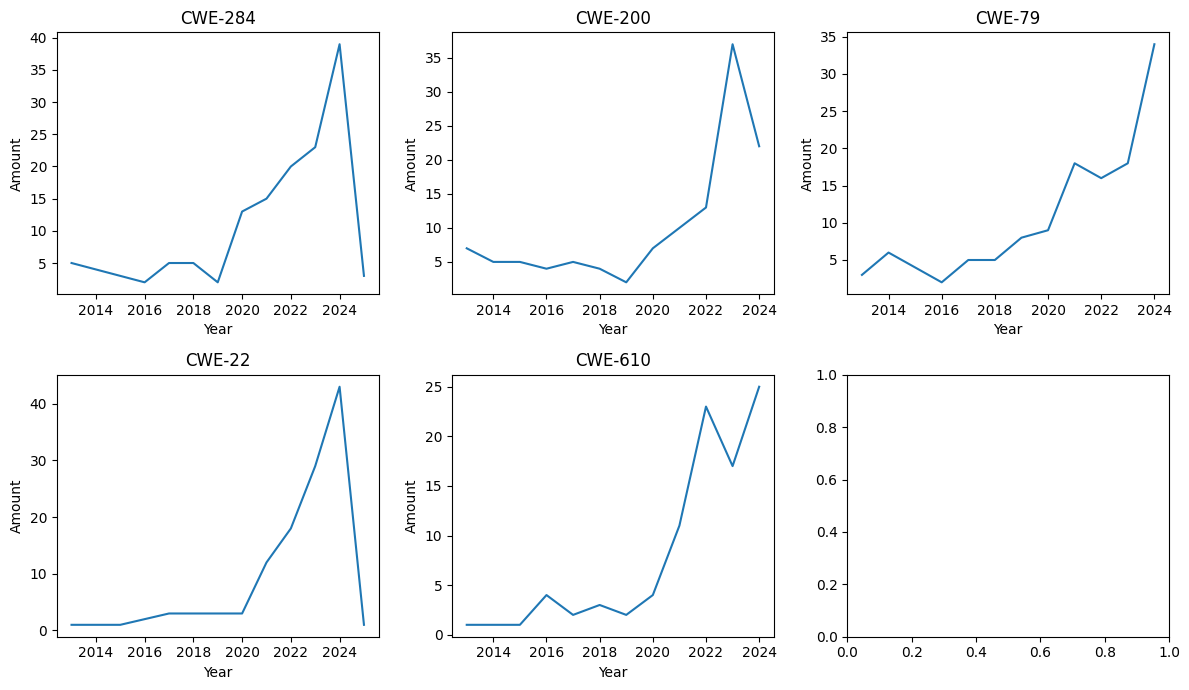

In [185]:
possible_to_sample_cwes = clustered_filtered_data.explode("clustered_cwe_id").select("clustered_cwe_id", "vulnerability_id").drop_nulls().unique(["clustered_cwe_id", "vulnerability_id"]).to_series().value_counts().sort(
    "count", descending=True
).filter(pl.col("count") < 200)

vulnerability_year = python_vulnerability_fixes.select("vulnerability_id", "patch_time").with_columns(pl.col("patch_time").cast(pl.Date).dt.year().alias("year"))
vulnerabilities_types_per_year = clustered_filtered_data.join(
    vulnerability_year, on="vulnerability_id"
).explode("clustered_cwe_id").unique(["clustered_cwe_id", "vulnerability_id", "year"]).group_by("clustered_cwe_id", "year").agg(pl.col("vulnerability_id").count().alias("count")).sort("year")

fig,axes = plt.subplots(nrows=2, ncols=3,figsize=(12, 7))

for idx, cwe_id in enumerate(possible_to_sample_cwes.select("clustered_cwe_id").to_series()):
    print(cwe_id)
    data = vulnerabilities_types_per_year.filter(pl.col("clustered_cwe_id") == cwe_id).to_pandas()
    ax = plt.subplot(2, 3, idx+1)
    ax.set_title(cwe_id)
    ax.set_xlabel("Year")
    ax.set_ylabel("Amount")
    ax.plot(data["year"], data["count"], label=cwe_id)
fig.tight_layout()

In [186]:
clustered_filtered_data.describe()

statistic,commit,repo,new_file,patch,code_unit_after_fix,vulnerability_id,cwe_id,old_file,code_unit_before_fix,clustered_cwe_id
str,str,str,str,str,str,str,f64,str,str,f64
"""count""","""2553""","""2553""","""2553""","""2553""","""2553""","""2553""",2553.0,"""2553""","""2553""",2553.0
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0""",0.0
"""mean""",null,null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null,null
"""min""","""001b0634cd309e372edb6d7d95d083…","""389ds/389-ds-base""","""CalendarinhoApp/authentication…","""@@ -1 +1 @@ -__version__ = ""1.…","""""","""2013-0212""",null,"""CalendarinhoApp/authentication…","""""",null
"""25%""",null,null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null,null
"""max""","""ffc095a3e5acc1c404773a0510e6d0…","""zwczou/weixin-python""","""zproject/urls.py""","""@@ -99,7 +99,9 @@ extern ""C"" {…","""} else { actionsTempla…","""GHSA-x563-6hqv-26mr""",null,"""zproject/urls.py""","""}, ""scope"": { …",null


### Jensen-Shannon Divergence metric

In [187]:
import polars as pl
import numpy as np
from scipy.spatial.distance import jensenshannon

vulnerability_year = python_vulnerability_fixes.select("vulnerability_id", "patch_time").with_columns(pl.col("patch_time").cast(pl.Date).dt.year().alias("year"))
data_with_year = clustered_filtered_data.join(vulnerability_year, on="vulnerability_id").explode("cwe_id")

# Ensure 'year' is treated as an integer
data_with_year = data_with_year.with_columns(pl.col("year").cast(pl.Int32)).filter(pl.col("year") < 2025)

# Aggregate counts of vulnerabilities per year per CWE
dist = data_with_year.group_by(["year", "cwe_id"]).agg(pl.count().alias("count"))

# Get unique years
years = dist["year"].unique().sort()
if len(years) < 2:
    raise ValueError("Dataset must have at least two different years for comparison.")

# Convert into a probability distribution per year
prob_distributions = {}
total_counts_per_year = dist.group_by("year").agg(pl.sum("count").alias("total"))

# Normalize distributions
for year in years:
    year_data = dist.filter(pl.col("year") == year)
    total = total_counts_per_year.filter(pl.col("year") == year)["total"][0]
    prob_distribution = year_data.with_columns((pl.col("count") / total).alias("prob"))
    prob_distributions[year] = dict(zip(prob_distribution["cwe_id"], prob_distribution["prob"]))

# Get all unique CWE IDs to align distributions
all_cwe_ids = set().union(*[set(p.keys()) for p in prob_distributions.values()])

# Convert distributions into aligned probability vectors
def get_probability_vector(year):
    return np.array([prob_distributions[year].get(cwe, 0) for cwe in all_cwe_ids])

# Compute JSD between consecutive years
jsd_results = []
for i in range(len(years) - 1):
    year1, year2 = years[i], years[i + 1]
    p = get_probability_vector(year1)
    q = get_probability_vector(year2)
    jsd = jensenshannon(p, q)
    jsd_results.append((year1, year2, jsd))

# Convert results into a DataFrame and display
jsd_df = pl.DataFrame(jsd_results, schema=["Year1", "Year2", "JSD_Value"])
print(jsd_df)

shape: (11, 3)
┌───────┬───────┬───────────┐
│ Year1 ┆ Year2 ┆ JSD_Value │
│ ---   ┆ ---   ┆ ---       │
│ i64   ┆ i64   ┆ f64       │
╞═══════╪═══════╪═══════════╡
│ 2013  ┆ 2014  ┆ 0.660044  │
│ 2014  ┆ 2015  ┆ 0.490783  │
│ 2015  ┆ 2016  ┆ 0.705995  │
│ 2016  ┆ 2017  ┆ 0.688352  │
│ 2017  ┆ 2018  ┆ 0.658297  │
│ …     ┆ …     ┆ …         │
│ 2019  ┆ 2020  ┆ 0.650075  │
│ 2020  ┆ 2021  ┆ 0.624772  │
│ 2021  ┆ 2022  ┆ 0.537707  │
│ 2022  ┆ 2023  ┆ 0.49521   │
│ 2023  ┆ 2024  ┆ 0.459022  │
└───────┴───────┴───────────┘


/var/folders/cy/xkclg4xd0gjglf9yxn33fv6r0000gn/T/ipykernel_49728/1897575878.py:12: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  dist = data_with_year.group_by(["year", "cwe_id"]).agg(pl.count().alias("count"))
/var/folders/cy/xkclg4xd0gjglf9yxn33fv6r0000gn/T/ipykernel_49728/1897575878.py:47: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  jsd_df = pl.DataFrame(jsd_results, schema=["Year1", "Year2", "JSD_Value"])


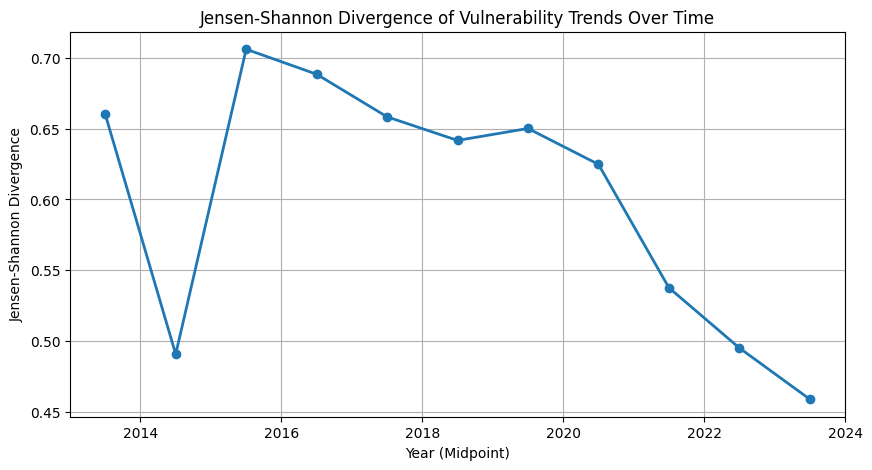

In [188]:
import matplotlib.pyplot as plt

# Extract values for plotting
years1 = jsd_df["Year1"].to_list()
years2 = jsd_df["Year2"].to_list()
jsd_values = jsd_df["JSD_Value"].to_list()

# Compute mid-points of year pairs for plotting
mid_years = [(y1 + y2) / 2 for y1, y2 in zip(years1, years2)]

# Plot JSD over time
plt.figure(figsize=(10, 5))
plt.plot(mid_years, jsd_values, marker='o', linestyle='-', linewidth=2, markersize=6)

# Labels and title
plt.xlabel("Year (Midpoint)")
plt.ylabel("Jensen-Shannon Divergence")
plt.title("Jensen-Shannon Divergence of Vulnerability Trends Over Time")
plt.grid(True)

# Show the plot
plt.show()
